# Qiskit Aer: Pulse simulation of two qubits using a Duffing oscillator model

This notebook shows how to use the Qiskit Aer pulse simulator, which simulates experiments specified as pulse `Schedule` objects at the Hamiltonian level. The simulator solves the Schrodinger equation for a specified Hamiltonian model and pulse `Schedule` in the frame of the drift Hamiltonian.

In particular, in this tutorial we will: 
- Construct a model of a two qubit superconducting system.
- Calibrate $\pi$ pulses on each qubit in the simulated system.
- Observe cross-resonance oscillations when driving qubit 1 with target qubit 0.

The Introduction outlines the concepts and flow of this notebook.

## 1. Introduction <a name='introduction'></a>

The main sections proceed as follows.

### Section 3: Duffing oscillator model

To simulate a physical system, it is necessary to specify a model. In this notebook, we will model superconducting qubits as a collection of *Duffing oscillators*. The model is specified in terms of the following parameters:

-  Each Duffing oscillator is specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which result in the Hamiltonian terms:
\begin{equation}
    2\pi\nu a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1) + 2 \pi r (a + a^\dagger) \times D(t),
\end{equation}
where $D(t)$ is the signal on the drive channel for the qubit, and $a^\dagger$ and $a$ are, respectively, the creation and annihilation operators for the qubit. Note that the drive strength $r$ sets the scaling of the control term, with $D(t)$ assumed to be a complex and unitless number satisfying $|D(t)| \leq 1$. 
-  A coupling between a pair of oscillators $(l,k)$ is specified by the coupling strength $J$, resulting in an exchange coupling term:
\begin{equation}
    2 \pi J (a_l a_k^\dagger + a_l^\dagger a_k),
\end{equation}
where the subscript denotes which qubit the operators act on.
- Additionally, for numerical simulation, it is necessary to specify a cutoff dimension; the Duffing oscillator model is *infinite dimensional*, and computer simulation requires restriction of the operators to a finite dimensional subspace.

**In the code:** We will define a model of the above form for two coupled qubits using the helper function `duffing_system_model`.

### Section 4: $\pi$-pulse calibration using Ignis

Once the model is defined, we will calibrate $\pi$-pulses on each qubit. A $\pi$-pulse is defined as a pulse on the drive channel of a qubit that "flips" the qubit; i.e. that takes the ground state to the first excited state, and the first excited state to the ground state.

We will experimentally find a $\pi$-pulse for each qubit using the following procedure:
- A fixed pulse shape is set - in this case it will be a Gaussian pulse.
- A sequence of experiments is run, each consisting of a Gaussian pulse on the qubit, followed by a measurement, with each experiment in the sequence having a subsequently larger amplitude for the Gaussian pulse.
- The measurement data is fit, and the pulse amplitude that completely flips the qubit is found (i.e. the $\pi$-pulse amplitude).

**In the code:** Using Ignis we will construct `Schedule` objects for the above experiments, then fit the data to find the $\pi$-pulse amplitudes. 

### Section 5: Cross-resonance oscillations

Once the $\pi$-pulses are calibrated, we will simulate the effects of cross-resonance driving on qubit $1$ with target qubit $0$. This means that we will drive qubit $1$ at the frequency of qubit $0$, with the goal of observing that the trajectory and oscillations of qubit $0$ *depends* on the state of qubit $1$. This phenomenon provides a basis for creating two-qubit *controlled* gates. Note: This section requires the calibration of the $\pi$-pulse in Section 4.

To observe cross-resonance driving, we will use experiments very similar to the $\pi$-pulse calibration case:
- Initially, qubit $1$ is either left in the ground state, or is driven to its first excited state using the $\pi$-pulse found in Section 4.
- A sequence of experiments is run, each consisting of a Gaussian pulse on qubit $1$ driven at the frequency of qubit $0$, followed by a measurement of both qubits, with each experiment of the sequence having a subsequently larger amplitude for the Gaussian pulse.

**In the code:** Functions for defining the experiments and visualizing the data are constructed, including a visualization of the trajectory of the target qubit on the Bloch sphere.

## 2. Imports <a name='imports'></a>

This notebook makes use of the following imports.

In [1]:
import numpy as np
from scipy.optimize import curve_fit, root

# visualization tools
import matplotlib.pyplot as plt
from qiskit.visualization.bloch import Bloch

Import qiskit libraries for working with `pulse` and calibration:

In [2]:
import qiskit.pulse as pulse
from qiskit.pulse.commands.parametric_pulses import Gaussian, GaussianSquare
from qiskit.compiler import assemble

from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

Imports for qiskit pulse simulator: 

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

## 3. Duffing oscillator system model <a name='duffing'></a>

An object representing a model for a collection of Duffing oscillators can be constructed using the `duffing_system_model` function. Here we construct a $2$ Duffing oscillator model with cutoff dimension $3$.

In [4]:
# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {(0,1): 0.002e9}

# sample duration for pulse instructions 
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

The function `duffing_system_model` returns a `PulseSystemModel` object, which is a general object for storing model information required for simulation with the `PulseSimulator`.

## 4 Calibrating $\pi$ pulses on each qubit using Ignis <a name='rabi'></a>

As described in the introduction, we now calibrate $\pi$ pulses on each qubit in `two_qubit_model`. The experiments in this calibration procedure are known as *Rabi experiments*, and the data we will observe are known as *Rabi oscillations*.

### 4.1 Constructing the schedules

We construct the schedules using the `rabi_schedules` function in Ignis. To do this, we need to supply an `InstructionScheduleMap` containing a measurement schedule.

In [5]:
# list of qubits to be used throughout the notebook
qubits = [0, 1]

# Construct a measurement schedule and add it to an InstructionScheduleMap
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_width = 1150
meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                            sigma=meas_sigma, width=meas_width)

acq_sched = pulse.Acquire(meas_samples, pulse.AcquireChannel(0), pulse.MemorySlot(0))
acq_sched += pulse.Acquire(meas_samples, pulse.AcquireChannel(1), pulse.MemorySlot(1))

measure_sched = pulse.Play(meas_pulse, pulse.MeasureChannel(0)) | pulse.Play(meas_pulse, pulse.MeasureChannel(1)) | acq_sched

inst_map = pulse.InstructionScheduleMap()
inst_map.add('measure', qubits, measure_sched)

Next, construct the Rabi schedules.

In [6]:
# construct Rabi experiments
drive_amps = np.linspace(0, 0.9, 21)
drive_sigma = 16
drive_duration = 128
drive_channels = [pulse.DriveChannel(0), pulse.DriveChannel(1)]


rabi_experiments, rabi_amps = rabi_schedules(amp_list=drive_amps, 
                                             qubits=qubits, 
                                             pulse_width=drive_duration, 
                                             pulse_sigma=drive_sigma,
                                             drives=drive_channels,
                                             inst_map=inst_map,
                                             meas_map=[[0, 1]])

The `Schedule`s in `rabi_schedules` correspond to experiments to generate Rabi oscillations on both qubits in parallel. Each experiment consists of a Gaussian pulse on the qubits of a given magnitude, followed by measurement.

For example:

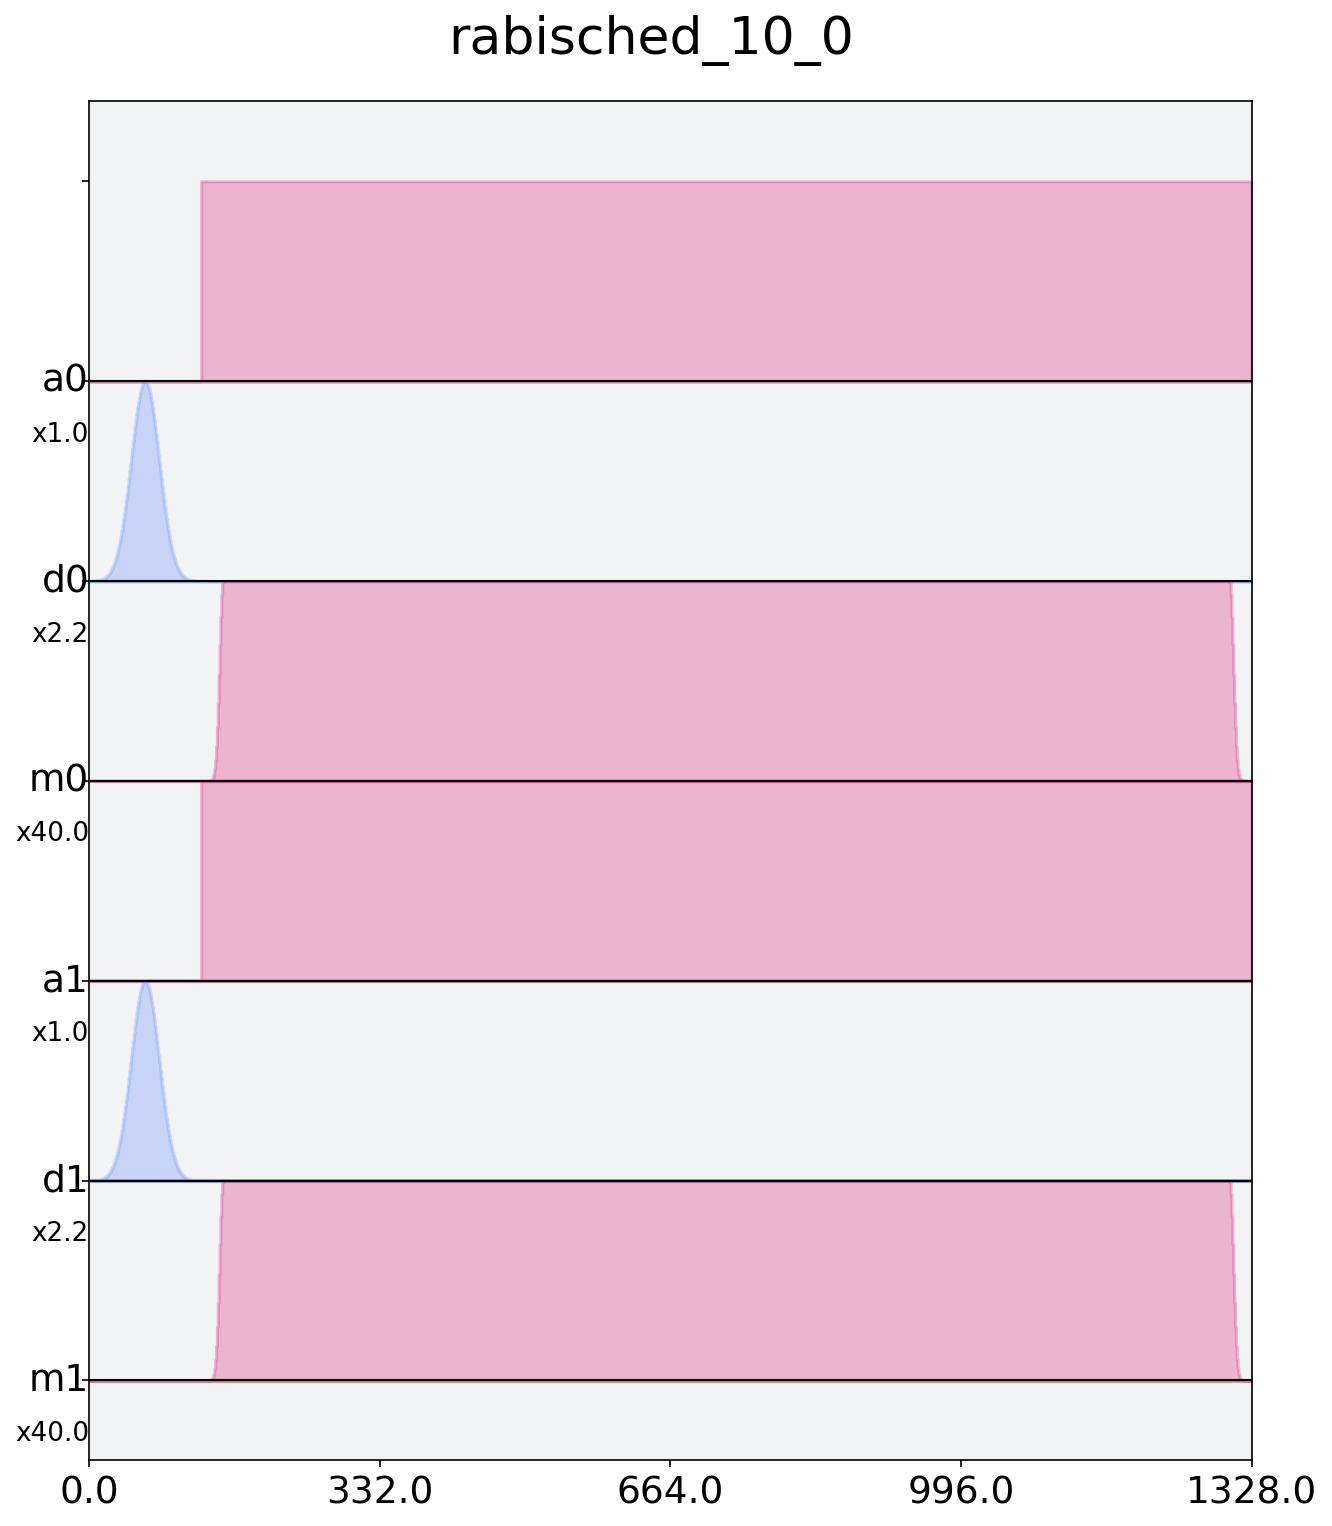

In [7]:
rabi_experiments[10].draw()

### 4.2 Simulate the Rabi experiments

To simulate the Rabi experiments, assemble the `Schedule` list into a qobj. When assembling, pass the `PulseSimulator` as the backend.

Here, we want to use local oscillators with frequencies automatically computed from Duffing model Hamiltonian.

In [8]:
# instantiate the pulse simulator
backend_sim = PulseSimulator()

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj = assemble(rabi_experiments, 
                     backend=backend_sim, 
                     qubit_lo_freq=qubit_lo_freq,
                     meas_level=1, 
                     meas_return='avg',
                     shots=512)

Run the simulation using the simulator backend.

In [9]:
# run the simulation
rabi_result = backend_sim.run(rabi_qobj, two_qubit_model).result()

### 4.3 Fit and plot the data

Next, we use `RabiFitter` in Ignis to fit the data, extract the $\pi$-pulse amplitude, and then plot the data.

Pi Amp: 0.631107
Pi Amp: 0.636891


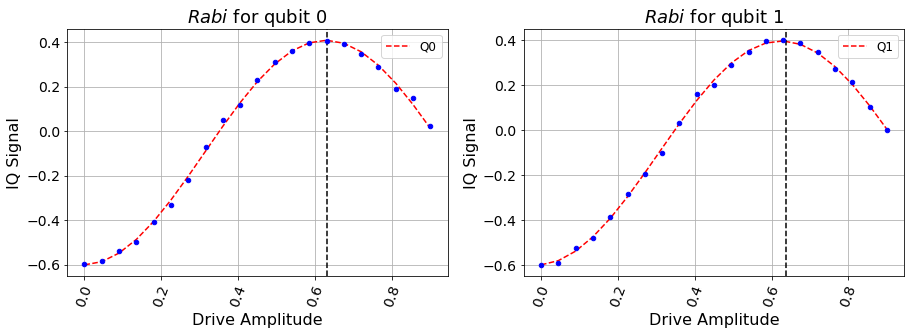

In [10]:
rabifit = RabiFitter(rabi_result, rabi_amps, qubits, fit_p0 = [0.5,0.5,0.6,1.5])

plt.figure(figsize=(15, 10))
q_offset = 0
for qubit in qubits:
    ax = plt.subplot(2, 2, qubit + 1)
    rabifit.plot(qubit, ax=ax)
    print('Pi Amp: %f'%rabifit.pi_amplitude(qubit))
plt.show()

Plotted is the averaged IQ data for observing each qubit. Observe that here, each qubit oscillates between the 0 and 1 state. The amplitude at which a given qubit reaches the peak of the oscillation is the desired $\pi$-pulse amplitude.

## 5. Oscillations from cross-resonance drive <a name='cr'></a>

Next, we simulate the effects of a cross-resonance drive on qubit $1$ with target qubit $0$, observing that the trajectory and oscillations of qubit $0$ *depends* on the state of qubit $1$.

**Note:** This section depends on the $\pi$-pulse calibrations of Section 2.

### 5.1 Cross-resonance `ControlChannel` indices

Driving qubit $1$ at the frequency of qubit $0$ requires use of a pulse `ControlChannel`. The model generating function `duffing_system_model`, automatically sets up `ControlChannels` for performing cross-resonance drives between pairs of coupled qubits. The index of the `ControlChannel` for performing a particular cross-resonance drive is retrievable using the class method `control_channel_index` on the returned `PulseSystemModel`. For example, to get the `ControlChannel` index corresponding to a CR drive on qubit 1 with target 0, call the function `control_channel_index` with the tuple `(1,0)`:

In [11]:
two_qubit_model.control_channel_index((1,0))

1

Hence, to perform a cross-resonance drive on qubit $1$ with target qubit $0$, use `ControlChannel(1)`. This will be made use of when constructing `Schedule` objects in this section.

### 5.2 Functions to generate the experiment list, and analyze the output

First, we define a function `cr_drive_experiments`, which, given the drive and target indices, and the option to either start with the drive qubit in the ground or excited state, returns a list of experiments for observing the oscillations.

In [12]:
# store the pi amplitudes from Section 2 in a list
pi_amps = [rabifit.pi_amplitude(0), rabifit.pi_amplitude(1)]

def cr_drive_experiments(drive_idx, 
                         target_idx, 
                         flip_drive_qubit = False,
                         cr_drive_amps=np.linspace(0, 0.9, 16),
                         cr_drive_samples=800,
                         cr_drive_sigma=4,
                         pi_drive_samples=128,
                         pi_drive_sigma=16):
    """Generate schedules corresponding to CR drive experiments.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        flip_drive_qubit (bool): whether or not to start the driven qubit in the ground or excited state
        cr_drive_amps (array): list of drive amplitudes to use
        cr_drive_samples (int): number samples for each CR drive signal
        cr_drive_sigma (float): standard deviation of CR Gaussian pulse
        pi_drive_samples (int): number samples for pi pulse on drive
        pi_drive_sigma (float): standard deviation of Gaussian pi pulse on drive

    Returns:
        list[Schedule]: A list of Schedule objects for each experiment
    """
    
    # Construct measurement commands to be used for all schedules
    meas_amp = 0.025
    meas_samples = 1200
    meas_sigma = 4
    meas_width = 1150
    meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                               sigma=meas_sigma, width=meas_width)

    acq_sched = pulse.Acquire(meas_samples, pulse.AcquireChannel(0), pulse.MemorySlot(0))
    acq_sched += pulse.Acquire(meas_samples, pulse.AcquireChannel(1), pulse.MemorySlot(1))
    
    # create measurement schedule
    measure_sched = (pulse.Play(meas_pulse, pulse.MeasureChannel(0)) | 
                     pulse.Play(meas_pulse, pulse.MeasureChannel(1))| 
                     acq_sched)
    
    # Create schedule
    schedules = []
    for ii, cr_drive_amp in enumerate(cr_drive_amps):
        
        # pulse for flipping drive qubit if desired
        pi_pulse = Gaussian(duration=pi_drive_samples, amp=pi_amps[drive_idx], sigma=pi_drive_sigma)

        # cr drive pulse
        cr_width = cr_drive_samples - 2*cr_drive_sigma*4
        cr_rabi_pulse = GaussianSquare(duration=cr_drive_samples, 
                                       amp=cr_drive_amp, 
                                       sigma=cr_drive_sigma,
                                       width=cr_width)

        # add commands to schedule
        schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)

        # flip drive qubit if desired
        if flip_drive_qubit:
            schedule += pulse.Play(pi_pulse, pulse.DriveChannel(drive_idx))
        
        # do cr drive
        # First, get the ControlChannel index for CR drive from drive to target
        cr_idx = two_qubit_model.control_channel_index((drive_idx, target_idx))
        schedule += pulse.Play(cr_rabi_pulse, pulse.ControlChannel(cr_idx))  << schedule.duration
        
        
        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    return schedules

Next we create two functions for observing the data:
- `plot_cr_pop_data` - for plotting the oscillations between the ground state and the first excited state
- `plot_bloch_sphere` - for viewing the trajectory of the target qubit on the bloch sphere

In [13]:
def plot_cr_pop_data(drive_idx, 
                     target_idx, 
                     sim_result, 
                     cr_drive_amps=np.linspace(0, 0.9, 16)):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        sim_result (Result): results of simulation
        cr_drive_amps (array): list of drive amplitudes to use for axis labels
    """
    
    amp_data_Q0 = []
    amp_data_Q1 = []

    for exp_idx in range(len(cr_drive_amps)):
        exp_mem = sim_result.get_memory(exp_idx)
        amp_data_Q0.append(np.abs(exp_mem[0]))
        amp_data_Q1.append(np.abs(exp_mem[1]))

    plt.plot(cr_drive_amps, amp_data_Q0, label='Q0')
    plt.plot(cr_drive_amps, amp_data_Q1, label='Q1')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('CR (Target Q{0}, driving on Q{1})'.format(target_idx, drive_idx), fontsize=20)
    plt.grid(True)

def bloch_vectors(drive_idx, drive_energy_level, sim_result):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        drive_energy_level (int): energy level of drive qubit at start of CR drive
        sim_result (Result): results of simulation
    
    Returns:
        list: list of Bloch vectors corresponding to the final state of the target qubit
              for each experiment
    """
    
    # get the dimension used for simulation
    dim = int(np.sqrt(len(sim_result.get_statevector(0))))
    
    
    # get the relevant dressed state indices
    idx0 = 0
    idx1 = 0
    if drive_idx == 0:
        if drive_energy_level == 0:
            idx0, idx1 = 0, dim
        elif drive_energy_level == 1:
            idx0, idx1 = 1, dim + 1
    if drive_idx == 1:
        if drive_energy_level == 0:
            idx0, idx1 = 0, 1
        elif drive_energy_level == 1:
            idx0, idx1 = dim, dim + 1

    # construct Pauli operators for correct dressed manifold
    state0 = np.array([two_qubit_model.hamiltonian._estates[idx0]])
    state1 = np.array([two_qubit_model.hamiltonian._estates[idx1]])
    
    outer01 = np.transpose(state0)@state1
    outer10 = np.transpose(state1)@state0
    outer00 = np.transpose(state0)@state0
    outer11 = np.transpose(state1)@state1
    
    X = outer01 + outer10
    Y = -1j*outer01 + 1j*outer10
    Z = outer00 - outer11
    
    # function for computing a single bloch vector
    bloch_vec = lambda vec: np.real(np.array([np.conj(vec)@X@vec, np.conj(vec)@Y@vec, np.conj(vec)@Z@vec]))
    
    return [bloch_vec(sim_result.get_statevector(idx)) for idx in range(len(sim_result.results))]

def plot_bloch_sphere(bloch_vectors):
    """Given a list of Bloch vectors, plot them on the Bloch sphere

    Args:
        bloch_vectors (list): list of bloch vectors
    """
    sphere = Bloch()
    sphere.add_points(np.transpose(bloch_vectors))
    sphere.show()

### 5.3 Drive qubit 1 to observe CR oscillations on qubit 0

#### Qubit 1 in the ground state

First, we drive with both qubit 0 and qubit 1 in the ground state.

In [14]:
# construct experiments
drive_idx = 1
target_idx = 0
flip_drive = False
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

Run the simulation:

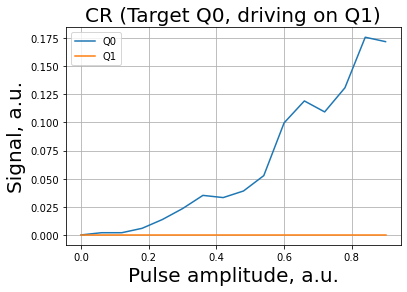

In [15]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

Observe that qubit 1 remains in the ground state, while excitations are driven in qubit 0.

We may also observe the trajectory of qubit 0 on the Bloch sphere:

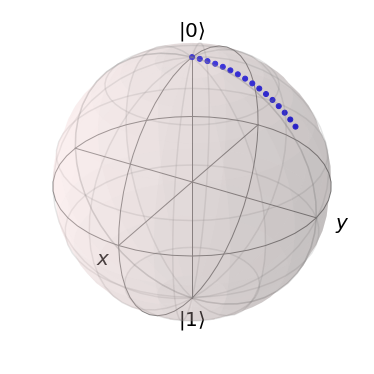

In [16]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

#### Qubit 1 in the first excited state

Next, we again perform a CR drive qubit 1 with qubit 0 as the target, but now we start each experiment by flipping qubit 1 into the first excited state. 

In [17]:
# construct experiments, now with flip_drive == True
drive_idx = 1
target_idx = 0
flip_drive = True
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

In [ ]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

Observe that now qubit 1 is in the excited state, while oscillations are again being driven on qubit 0, now at a different rate as before.

Again, observe the trajectory of qubit 0 on the Bloch sphere:

In [ ]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

Here we see that qubit 0 takes a *different* trajectory on the Bloch sphere when qubit 1 is in the excited state. This is what enables controlled operations between two qubits.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright